In [ ]:
import os
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import plotly.express as px
import yfinance as yf





In [2]:
def read_stations(year, month):
    station_path = os.path.join("stations", year, month)
    all_merged_data = []

    # Check if the station folder exists; if not, return an empty DataFrame
    if not os.path.exists(station_path):
        print(f"Station path {station_path} does not exist.")
        return pd.DataFrame()  # Return empty DataFrame if folder is missing

    # Iterate through all station files in the folder
    for station_file in os.listdir(station_path):
        if station_file.endswith(".csv"):
            station_data = pd.read_csv(os.path.join(station_path, station_file))

            # Filter for Dortmund stations and exclude unwanted stations
            station_data = station_data[
                (station_data['city'] == "Dortmund") &  # Only include stations in Dortmund
                (~station_data['name'].str.contains("BAB|BAT|Autobahntankstelle", case=False, na=False))  # Exclude highway stations
            ]

            # Extract the date from the station file name
            date_in_file = station_file.split(".")[0].replace("-stations", "")
            # Merge station data with price data for the specific date
            merged_data = read_prices(year, month, date_in_file, station_data)
            all_merged_data.append(merged_data)

    # Combine all merged data into a single DataFrame; return an empty DataFrame if no data is available
    return pd.concat(all_merged_data, ignore_index=True) if all_merged_data else pd.DataFrame()

def read_prices(year, month, date_in_file, station_df):
    price_path = os.path.join("prices", year, month)
    price_file = os.path.join(price_path, f"{date_in_file}-prices.csv")

    # Check if the price file exists; if not, return an empty DataFrame
    if not os.path.exists(price_file):
        print(f"Price file {price_file} does not exist.")
        return pd.DataFrame()  # Return empty DataFrame if file is missing

    # Read price data and convert the 'date' column to datetime
    price_data = pd.read_csv(price_file)
    price_data['date'] = pd.to_datetime(price_data['date'])

    # Merge price data with station data based on 'station_uuid'
    price_data = price_data[['date', 'station_uuid', 'e10', 'e10change']]
    merged_data = pd.merge(price_data, station_df, left_on='station_uuid', right_on='uuid', how='inner')

    # Logic: Keep only the first price and subsequent rows where 'e10change' is 1
    filtered_data = []
    for station_uuid, group in merged_data.groupby('station_uuid'):
        group = group.sort_values('date')  # Sort by date
        first_row = group.iloc[0].to_dict()  # First price as a dictionary
        filtered_data.append(first_row)

        group = group.iloc[1:]  # Skip the first row
        subsequent_rows = group[group['e10change'] == 1].to_dict('records')  # Rows where 'e10change' is 1
        filtered_data.extend(subsequent_rows)

    # Convert the list of dictionaries to a DataFrame
    filtered_data = pd.DataFrame(filtered_data)

    # Fill missing 'e10' prices
    for i in filtered_data.index[filtered_data['e10'] == 0]:
        current_date = filtered_data.at[i, 'date']
        station_uuid = filtered_data.at[i, 'station_uuid']

        print(f"Missing price on {current_date.strftime('%Y-%m-%d')} for station UUID {station_uuid}")
        price_previous_day = find_price_previous_day(current_date, station_uuid)

        # If a valid price from the previous day is found, use it
        if price_previous_day is not None:
            filtered_data.at[i, 'e10'] = price_previous_day['e10']
            print(f"Applied last valid price: {price_previous_day['e10']}")

    # Remove stations with missing prices (where 'e10' is still 0)
    before_removal = len(filtered_data)
    filtered_data = filtered_data[filtered_data['e10'] != 0]
    after_removal = len(filtered_data)
    
    print(f"Removed {before_removal - after_removal} stations with missing prices.")

    return filtered_data

def find_price_previous_day(current_date, station_uuid):
    # Calculate the previous day's date
    previous_day = current_date - timedelta(days=1)
    previous_price_file = os.path.join(
        "prices", str(previous_day.year), f"{previous_day.month:02d}",
        f"{previous_day.year}-{previous_day.month:02d}-{previous_day.day:02d}-prices.csv"
    )

    # Check if the previous day's price file exists
    if not os.path.exists(previous_price_file):
        print(f"Previous price file {previous_price_file} does not exist.")
        return None

    # Read the previous day's price data
    previous_price_data = pd.read_csv(previous_price_file)
    previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])

    # Filter for the same station and a valid price
    previous_price = previous_price_data[
        (previous_price_data['station_uuid'] == station_uuid) &  # Same station
        (previous_price_data['e10'] != 0)  # Valid price
    ]

    # Return the most recent price for the station
    return previous_price.sort_values('date', ascending=False).iloc[0] if not previous_price.empty else None

result = []

for year in ["2023", "2024"]:
    months = ["11", "12"] if year == "2023" else [f"{i:02d}" for i in range(1, 11)]

    for month in months:
        # Read station and price data for the year and month
        price_data = read_stations(year, month)
        if not price_data.empty:
            result.append(price_data)

final_df = pd.concat(result, ignore_index=True) if result else pd.DataFrame()

Missing price on 2023-11-01 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2023-11-01 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2023-11-01 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2023-11-01 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 4 stations with missing prices.
Missing price on 2023-11-02 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2023-11-02 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2023-11-02 for station UUID 5915ebc0-e19e-47b8-bfce-0fbb3234ab54
Missing price on 2023-11-02 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2023-11-02 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 5 stations with missing prices.
Missing price on 2023-11-03 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2023-11-03 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\1501078935.py:41: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  price_data['date'] = pd.to_datetime(price_data['date'])


Missing price on 2024-10-27 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2024-10-27 for station UUID 27b7b18e-85a8-455d-863c-2f8dbdcf256d
Missing price on 2024-10-27 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2024-10-27 for station UUID 3eba12bf-7c1e-4b4a-a39f-2cb077115071
Missing price on 2024-10-27 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2024-10-27 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 6 stations with missing prices.
Missing price on 2024-10-28 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f


C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\1501078935.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 27b7b18e-85a8-455d-863c-2f8dbdcf256d


C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\1501078935.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e


C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\1501078935.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 3eba12bf-7c1e-4b4a-a39f-2cb077115071


C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\1501078935.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf


C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\1501078935.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825


C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\1501078935.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Removed 6 stations with missing prices.
Missing price on 2024-10-29 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2024-10-29 for station UUID 27b7b18e-85a8-455d-863c-2f8dbdcf256d
Missing price on 2024-10-29 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2024-10-29 for station UUID 3eba12bf-7c1e-4b4a-a39f-2cb077115071
Missing price on 2024-10-29 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2024-10-29 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 6 stations with missing prices.
Missing price on 2024-10-30 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2024-10-30 for station UUID 27b7b18e-85a8-455d-863c-2f8dbdcf256d
Missing price on 2024-10-30 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2024-10-30 for station UUID 3eba12bf-7c1e-4b4a-a39f-2cb077115071
Missing price on 2024-10-30 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2

In [3]:
final_df = final_df.drop(['uuid'], axis=1)
final_df['date'] = pd.to_datetime(final_df['date'], utc=True)
final_df['date'] = final_df['date'].dt.tz_localize(None)

final_df.head(5)

date                          station_uuid    e10  e10change  \
0 2023-11-01 03:23:46  005056ba-7cb6-1ed2-bceb-57e186e40d16  1.749          1   
1 2023-11-01 04:13:47  005056ba-7cb6-1ed2-bceb-57e186e40d16  1.739          1   
2 2023-11-01 04:53:10  005056ba-7cb6-1ed2-bceb-57e186e40d16  1.769          1   
3 2023-11-01 05:53:38  005056ba-7cb6-1ed2-bceb-57e186e40d16  1.829          1   
4 2023-11-01 06:28:30  005056ba-7cb6-1ed2-bceb-57e186e40d16  1.819          1   

              name brand          street house_number post_code      city  \
0  star Tankstelle  STAR  Evinger Straße          517     44339  Dortmund   
1  star Tankstelle  STAR  Evinger Straße          517     44339  Dortmund   
2  star Tankstelle  STAR  Evinger Straße          517     44339  Dortmund   
3  star Tankstelle  STAR  Evinger Straße          517     44339  Dortmund   
4  star Tankstelle  STAR  Evinger Straße          517     44339  Dortmund   

    latitude  longitude            first_active  \
0  51.573735   7.464103  2014-03-18 16:45:31+01   
1  51.573735   7.464103  2014-03-18 16:45:31+01   
2  51.573735   7.464103  2014-03-18 16:45:31+01   
3  51.573735   7.464103  2014-03-18 16:45:31+01   
4  51.573735   7.464103  2014-03-18 16:45:31+01   

                                   openingtimes_json  
0  {"openingTimes":[{"applicable_days":31,"period...  
1  {"openingTimes":[{"applicable_days":31,"period...  
2  {"openingTimes":[{"applicable_days":31,"period...  
3  {"openingTimes":[{"applicable_days":31,"period...  
4  {"openingTimes":[{"applicable_days":31,"period...

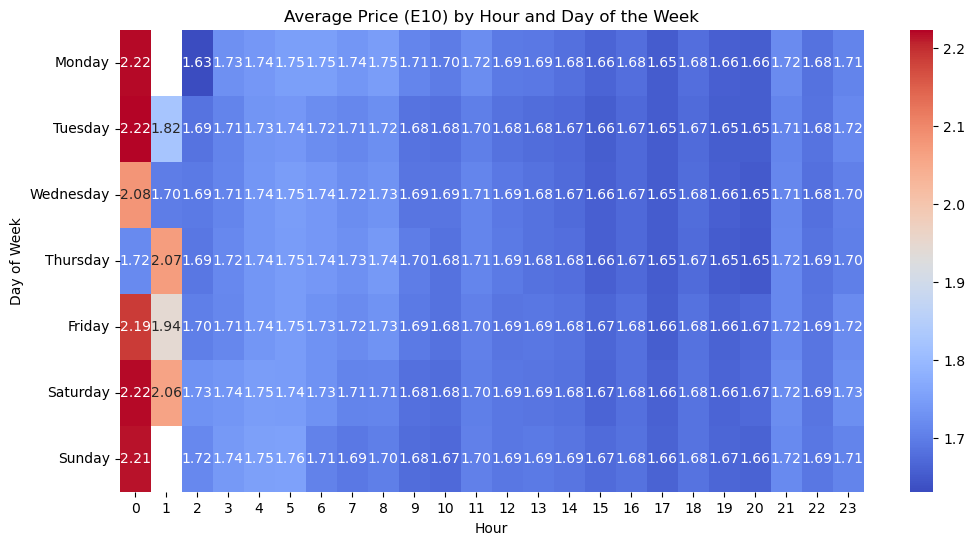

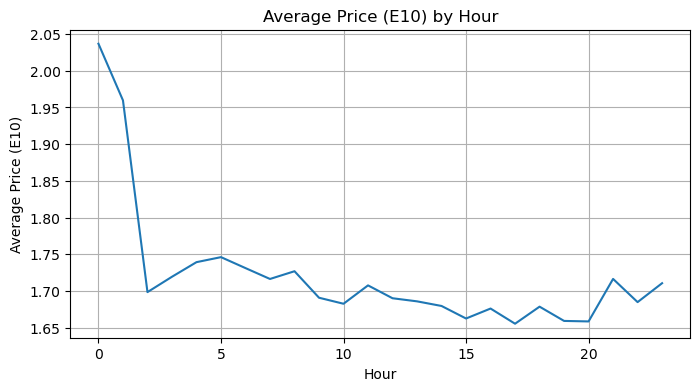

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\937266764.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_pattern.index, y=daily_pattern.values, palette="viridis")


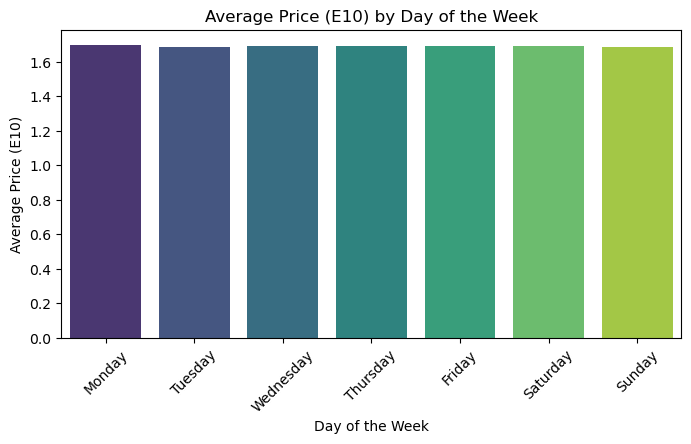

In [4]:
final_df['hour'] = final_df['date'].dt.hour
final_df['day_of_week'] = final_df['date'].dt.day_name()
hourly_pattern = final_df.groupby('hour')['e10'].mean().reset_index()
daily_pattern = final_df.groupby('day_of_week')['e10'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

heatmap_data = final_df.groupby(['day_of_week', 'hour'])['e10'].mean().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average Price (E10) by Hour and Day of the Week")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(data=hourly_pattern, x='hour', y='e10')
plt.title("Average Price (E10) by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Price (E10)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=daily_pattern.index, y=daily_pattern.values, palette="viridis")
plt.title("Average Price (E10) by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Price (E10)")
plt.xticks(rotation=45)
plt.show()

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\972550171.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


                                 mean       std
brand                                          
Tankstation Oespel (Calpam)  1.638774  0.037896
Calpam                       1.648744  0.038695
Klink                        1.662969  0.044337
OIL!                         1.668190  0.056379
T Xpress                     1.669715  0.058121
Markant (Tankautomat)        1.670442  0.055001
STAR                         1.671143  0.053084
SB                           1.671652  0.053467
HEM                          1.672608  0.055124
Q1                           1.675106  0.056705
ORLEN                        1.675821  0.054598
Classic Tankstelle           1.677084  0.058652
Markant                      1.677926  0.054557
Bavaria Petrol               1.679265  0.055162
BFT                          1.680041  0.055585
BFT Tankstelle               1.680704  0.058904
Mr. Wash Autoservice AG      1.680916  0.053397
Markenfreie TS               1.681785  0.057283
T                            1.683273  0

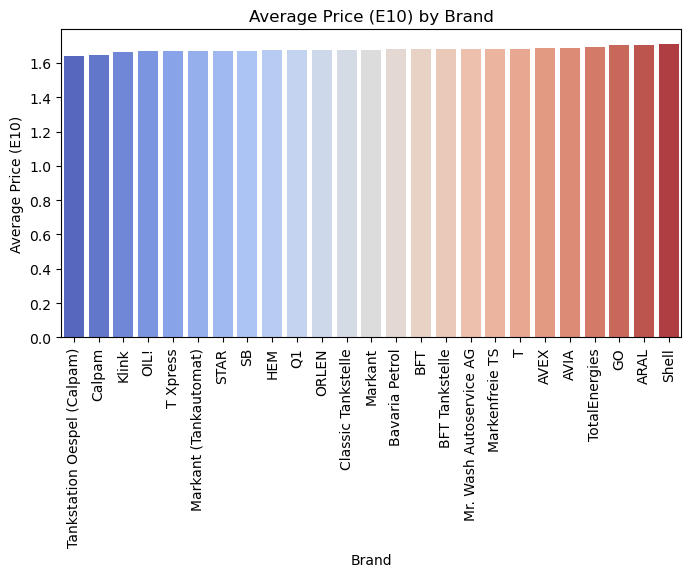

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\972550171.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


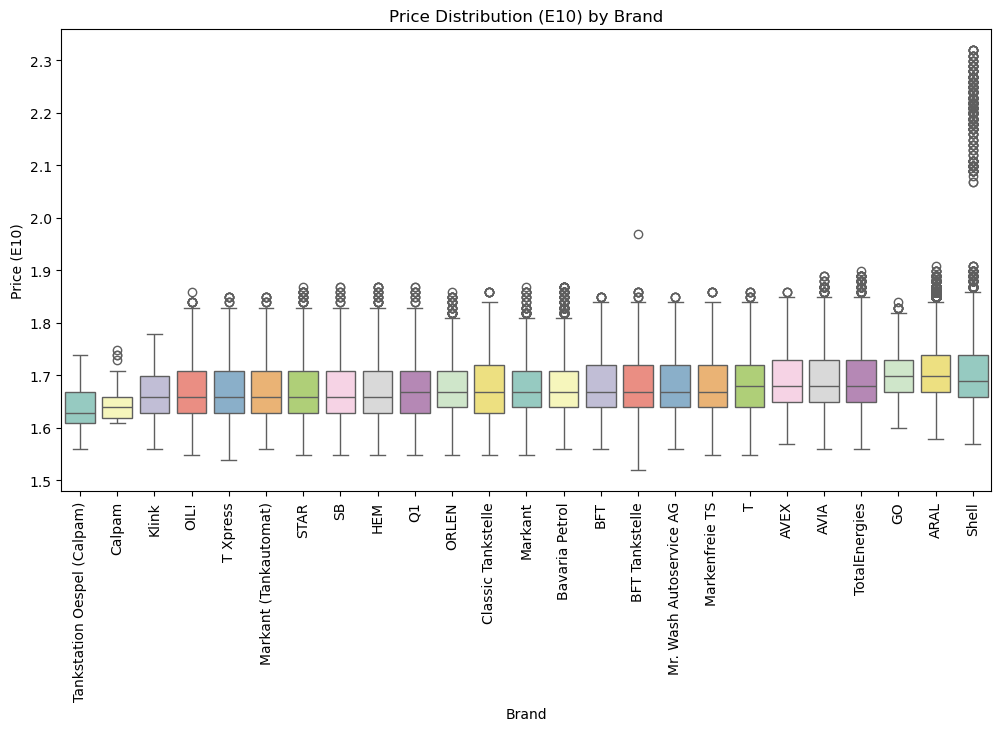

In [5]:
brand_stats = final_df.groupby('brand')['e10'].agg(['mean', 'std']).sort_values('mean', ascending=True)

print(brand_stats)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=brand_stats.reset_index(),
    x='brand',
    y='mean',
    order=brand_stats.index, 
    palette="coolwarm"
)
plt.title("Average Price (E10) by Brand")
plt.xlabel("Brand")
plt.ylabel("Average Price (E10)")
plt.xticks(rotation=90) 
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=final_df,
    x='brand',
    y='e10',
    order=brand_stats.index, 
    palette="Set3"
)
plt.title("Price Distribution (E10) by Brand")
plt.xlabel("Brand")
plt.ylabel("Price (E10)")
plt.xticks(rotation=90)  
plt.show()

Analyzing the Impact of Holidays on Fuel Prices

In [ ]:
# Load your holiday data (ensure you read the CSV correctly)
holiday_data = pd.read_csv('fcal_Nordrhein-Westfalen_2023.csv', sep=';', encoding='latin1')

# Display the first few rows and the columns of the holiday data to verify its structure
print("Holiday Data Structure:\n", holiday_data.head())
print("Holiday Data Columns:\n", holiday_data.columns)

# Rename only the relevant columns and ignore the extra ones (assume first three are the ones we need)
holiday_data = holiday_data.iloc[:, :3]  # Keep only the first 3 columns

# Rename the columns to more meaningful names
holiday_data.columns = ['start_date', 'end_date', 'holiday_name']

# Convert the start_date and end_date to datetime format (with timezone awareness)
holiday_data['start_date'] = pd.to_datetime(holiday_data['start_date'], format='%d.%m.%Y').dt.tz_localize('Europe/Berlin')
holiday_data['end_date'] = pd.to_datetime(holiday_data['end_date'], format='%d.%m.%Y').dt.tz_localize('Europe/Berlin')

# Filter holidays for 2023 and 2024 only
holiday_data_filtered = holiday_data[
    (holiday_data['start_date'].dt.year >= 2023) & (holiday_data['end_date'].dt.year <= 2024)
]

# Display the filtered holiday data
print("Filtered Holiday Data (2023 & 2024):\n", holiday_data_filtered)

# Assuming 'final_df' is your DataFrame containing fuel price data, inspect the structure as well
print("Fuel Price Data Structure:\n", final_df.head())
print("Fuel Price Data Columns:\n", final_df.columns)

# Convert the 'date' column to datetime format and localize it to the correct timezone
final_df['date'] = pd.to_datetime(final_df['date'], utc=True).dt.tz_convert('Europe/Berlin')

# Define a function to check the holiday status (before, during, after)
def get_holiday_status(date):
    for _, holiday in holiday_data_filtered.iterrows():
        if holiday['start_date'] <= date <= holiday['end_date']:
            return 'During Holiday'
    for _, holiday in holiday_data_filtered.iterrows():
        if date < holiday['start_date']:
            return 'Before Holiday'
        if date > holiday['end_date']:
            return 'After Holiday'
    return 'Not in Holiday'

# Apply the function to assign the holiday status
final_df['holiday_status'] = final_df['date'].apply(get_holiday_status)

# Check the unique values in the 'holiday_status' column to debug
print("Unique Holiday Status Values:", final_df['holiday_status'].unique())

# Filter the final_df to include only 2023 and 2024
final_df_filtered = final_df[final_df['date'].dt.year.isin([2023, 2024])]

# Check for missing data in 'e10' or 'holiday_status'
missing_data = final_df_filtered[['e10', 'holiday_status']].isnull().sum()
print("Missing data in 'e10' or 'holiday_status':\n", missing_data)

# Check variance within each group (before, during, after holiday)
group_variance = final_df_filtered.groupby('holiday_status')['e10'].var()
print("Variance within each group:\n", group_variance)

# Perform T-tests if variance is not zero and there is enough data
t_stat_before_during, p_val_before_during = None, None
t_stat_during_after, p_val_during_after = None, None

# Check for the presence of the 'Before Holiday' and 'During Holiday' categories
if 'Before Holiday' in final_df_filtered['holiday_status'].unique() and group_variance.get('Before Holiday', 0) > 0:
    t_stat_before_during, p_val_before_during = stats.ttest_ind(
        final_df_filtered[final_df_filtered['holiday_status'] == 'Before Holiday']['e10'],
        final_df_filtered[final_df_filtered['holiday_status'] == 'During Holiday']['e10'],
        equal_var=False
    )

if 'During Holiday' in final_df_filtered['holiday_status'].unique() and group_variance.get('During Holiday', 0) > 0:
    t_stat_during_after, p_val_during_after = stats.ttest_ind(
        final_df_filtered[final_df_filtered['holiday_status'] == 'During Holiday']['e10'],
        final_df_filtered[final_df_filtered['holiday_status'] == 'After Holiday']['e10'],
        equal_var=False
    )





Holiday Data Structure:
         Datum        Ende       Bezeichnung  Bemerkungen  Unnamed: 4
0  23.12.2022  06.01.2023  Weihnachtsferien          NaN         NaN
1  03.04.2023  15.04.2023       Osterferien          NaN         NaN
2  29.05.2023  30.05.2023     Pfingstferien          NaN         NaN
3  22.06.2023  04.08.2023      Sommerferien          NaN         NaN
4  02.10.2023  14.10.2023      Herbstferien          NaN         NaN
Holiday Data Columns:
 Index(['Datum', 'Ende', 'Bezeichnung', 'Bemerkungen', 'Unnamed: 4'], dtype='object')
Filtered Holiday Data (2023 & 2024):
                  start_date                  end_date      holiday_name
1 2023-04-03 00:00:00+02:00 2023-04-15 00:00:00+02:00       Osterferien
2 2023-05-29 00:00:00+02:00 2023-05-30 00:00:00+02:00     Pfingstferien
3 2023-06-22 00:00:00+02:00 2023-08-04 00:00:00+02:00      Sommerferien
4 2023-10-02 00:00:00+02:00 2023-10-14 00:00:00+02:00      Herbstferien
5 2023-12-21 00:00:00+01:00 2024-01-05 00:00:00+01:00  

 Statistical Analysis and  Data Visualization impact on price of holidays


In [33]:
import pandas as pd
import plotly.express as px
from scipy import stats

# Load holiday data
holiday_data = pd.read_csv('fcal_Nordrhein-Westfalen_2023.csv', sep=';', encoding='latin1')

# Keep relevant columns and rename them
holiday_data = holiday_data.iloc[:, :3]
holiday_data.columns = ['start_date', 'end_date', 'holiday_name']

# Convert to datetime format with timezone awareness
holiday_data['start_date'] = pd.to_datetime(holiday_data['start_date'], format='%d.%m.%Y').dt.tz_localize('Europe/Berlin')
holiday_data['end_date'] = pd.to_datetime(holiday_data['end_date'], format='%d.%m.%Y').dt.tz_localize('Europe/Berlin')

# Filter holidays for 2023 and 2024
holiday_data_filtered = holiday_data[
    (holiday_data['start_date'].dt.year >= 2023) & (holiday_data['end_date'].dt.year <= 2024)
]

# Assuming `final_df` contains fuel price data
# Convert 'date' to datetime and localize
final_df['date'] = pd.to_datetime(final_df['date'], utc=True).dt.tz_convert('Europe/Berlin')

# Robust holiday status assignment function
def assign_holiday_status(row, holiday_data):
    status = 'After Holiday'  # Default status
    for _, holiday in holiday_data.iterrows():
        if holiday['start_date'] <= row['date'] <= holiday['end_date']:
            return 'During Holiday'
        elif row['date'] < holiday['start_date']:
            status = 'Before Holiday'
            break
    return status

# Apply the function to assign holiday status
final_df['holiday_status'] = final_df.apply(assign_holiday_status, axis=1, holiday_data=holiday_data_filtered)

# Filter for relevant years
final_df_filtered = final_df[final_df['date'].dt.year.isin([2023, 2024])]

# Calculate summary statistics for each group
holiday_group_summary = final_df_filtered.groupby('holiday_status')['e10'].agg(['mean', 'std', 'count']).reset_index()

# Bar Graph: Show mean prices with error bars for standard deviation
fig_bar = px.bar(
    holiday_group_summary,
    x='holiday_status',
    y='mean',
    error_y='std',
    color='holiday_status',
    title='Average Fuel Prices Before, During, and After Holidays',
    labels={'holiday_status': 'Holiday Status', 'mean': 'Average Fuel Price (E10)'},
    text='mean'
)
fig_bar.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_bar.update_layout(yaxis_title="Average Fuel Price (E10)", xaxis_title="Holiday Status", showlegend=False)

# Box Plot: Show distribution of prices by holiday status
fig_box = px.box(
    final_df_filtered,
    x='holiday_status',
    y='e10',
    color='holiday_status',
    title='Distribution of Fuel Prices by Holiday Status',
    labels={'holiday_status': 'Holiday Status', 'e10': 'Fuel Price (E10)'},
    points="all"
)
fig_box.update_layout(yaxis_title="Fuel Price (E10)", xaxis_title="Holiday Status", showlegend=False)

# Perform T-tests to check significance between groups
t_stat_before_during, p_val_before_during = stats.ttest_ind(
    final_df_filtered[final_df_filtered['holiday_status'] == 'Before Holiday']['e10'],
    final_df_filtered[final_df_filtered['holiday_status'] == 'During Holiday']['e10'],
    equal_var=False
)

t_stat_during_after, p_val_during_after = stats.ttest_ind(
    final_df_filtered[final_df_filtered['holiday_status'] == 'During Holiday']['e10'],
    final_df_filtered[final_df_filtered['holiday_status'] == 'After Holiday']['e10'],
    equal_var=False
)

# Combine results of T-tests
t_test_results = [
    f"T-test Before vs During: t={t_stat_before_during:.2f}, p={p_val_before_during:.4f} "
    f"({'Significant' if p_val_before_during < 0.05 else 'Not Significant'})",
    f"T-test During vs After: t={t_stat_during_after:.2f}, p={p_val_during_after:.4f} "
    f"({'Significant' if p_val_during_after < 0.05 else 'Not Significant'})"
]

# Print T-test results
for result in t_test_results:
    print(result)

# Show the plots
fig_bar.show()
fig_box.show()


T-test Before vs During: t=84.33, p=0.0000 (Significant)
T-test During vs After: t=26.79, p=0.0000 (Significant)


impact of crude oil on price of (e10)

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\2905669015.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\2905669015.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\2905669015.py:44: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5996\2905669015.py:45: FutureWar

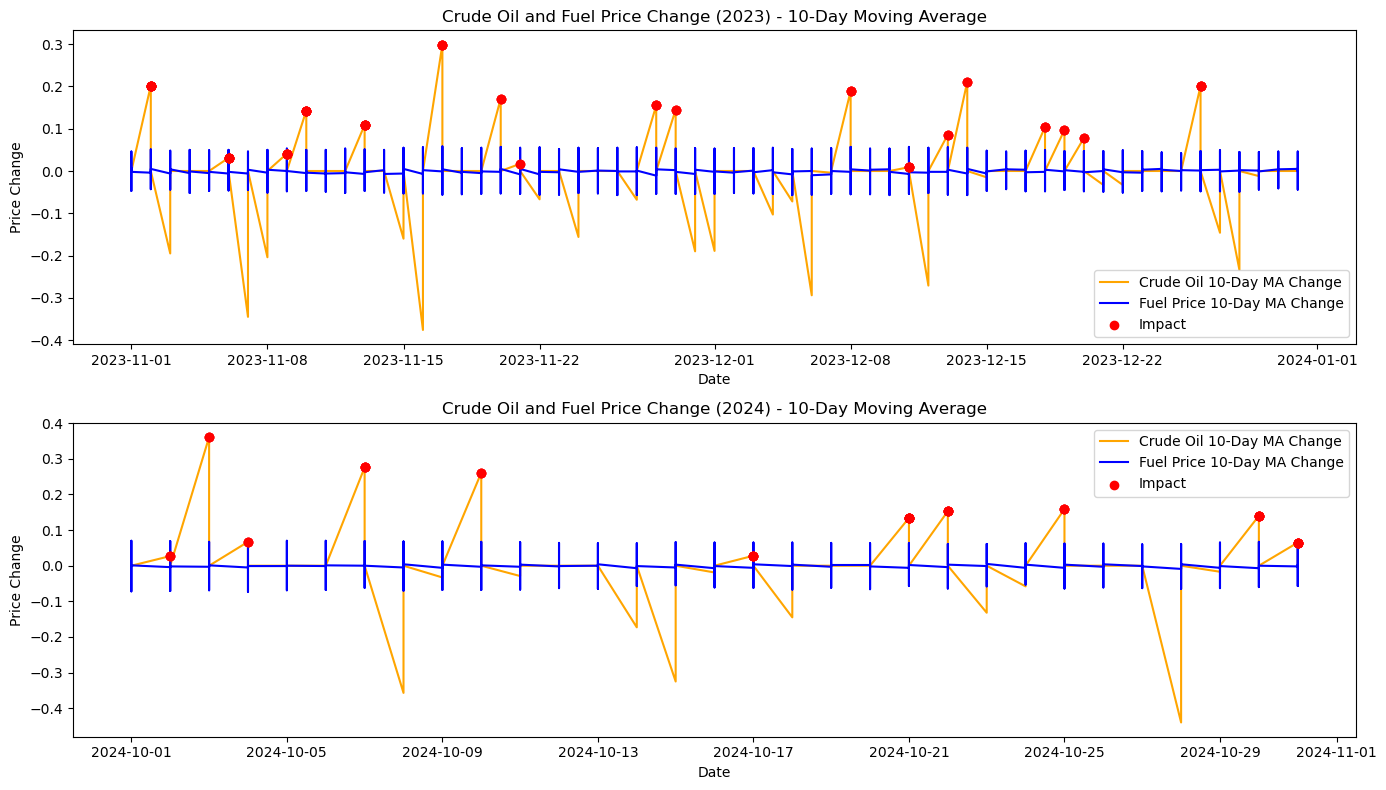

In [ ]:


# Step 1: Load crude oil data for 2023 and 2024
crude_oil_2023 = yf.download("CL=F", start="2023-01-01", end="2023-12-31", progress=False)
crude_oil_2024 = yf.download("CL=F", start="2024-01-01", end="2024-12-31", progress=False)

# Step 2: Flatten the multi-level columns (if present)
crude_oil_2023.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in crude_oil_2023.columns.values]
crude_oil_2024.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in crude_oil_2024.columns.values]

# Step 3: Reset index so that 'Date' is a regular column (not part of the index)
crude_oil_2023 = crude_oil_2023.reset_index()
crude_oil_2024 = crude_oil_2024.reset_index()

# Step 4: Extract relevant columns ('Date' and 'Close_CL=F')
crude_oil_2023_data = crude_oil_2023[['Date', 'Close_CL=F']]
crude_oil_2024_data = crude_oil_2024[['Date', 'Close_CL=F']]

# Step 5: Convert 'Date' to datetime and ensure it is in date format
crude_oil_2023_data['Date'] = pd.to_datetime(crude_oil_2023_data['Date']).dt.date
crude_oil_2024_data['Date'] = pd.to_datetime(crude_oil_2024_data['Date']).dt.date

# Step 6: Load fuel price data for the year 2023 and 2024
# Assuming final_df contains fuel price data (for E10)
final_df['date'] = pd.to_datetime(final_df['date']).dt.date  # Ensure 'date' is in date format

# Filter the fuel prices for 2023 and 2024
fuel_prices_2023 = final_df[(final_df['date'] >= pd.to_datetime("2023-01-01").date()) & 
                            (final_df['date'] <= pd.to_datetime("2023-12-31").date())]
fuel_prices_2024 = final_df[(final_df['date'] >= pd.to_datetime("2024-01-01").date()) & 
                            (final_df['date'] <= pd.to_datetime("2024-12-31").date())]

# Step 7: Merge crude oil and fuel price data for 2023 and 2024
merged_2023 = pd.merge(fuel_prices_2023[['date', 'e10']], crude_oil_2023_data[['Date', 'Close_CL=F']], 
                       left_on='date', right_on='Date', how='left')

merged_2024 = pd.merge(fuel_prices_2024[['date', 'e10']], crude_oil_2024_data[['Date', 'Close_CL=F']], 
                       left_on='date', right_on='Date', how='left')

# Step 8: Forward-fill missing data for the merged data
merged_2023['Close_CL=F'] = merged_2023['Close_CL=F'].fillna(method='ffill')
merged_2023['e10'] = merged_2023['e10'].fillna(method='ffill')

merged_2024['Close_CL=F'] = merged_2024['Close_CL=F'].fillna(method='ffill')
merged_2024['e10'] = merged_2024['e10'].fillna(method='ffill')

# Step 9: Define a function to calculate the moving average for the price changes
def calculate_price_changes(df, window=10):
    df['Crude_Oil_Change'] = df['Close_CL=F'].diff()
    df['Fuel_Price_Change'] = df['e10'].diff()
    df['Crude_Oil_MA'] = df['Crude_Oil_Change'].rolling(window=window).mean()
    df['Fuel_Price_MA'] = df['Fuel_Price_Change'].rolling(window=window).mean()
    return df

# Apply the moving average function on both 2023 and 2024 data
merged_2023 = calculate_price_changes(merged_2023, window=10)
merged_2024 = calculate_price_changes(merged_2024, window=10)

# Step 10: Identify when both Crude Oil and Fuel Price changes are positive or negative
merged_2023['Impact'] = np.where((merged_2023['Crude_Oil_MA'] > 0) & (merged_2023['Fuel_Price_MA'] > 0), 'Impact', 'No Impact')
merged_2024['Impact'] = np.where((merged_2024['Crude_Oil_MA'] > 0) & (merged_2024['Fuel_Price_MA'] > 0), 'Impact', 'No Impact')

# Step 11: Plot the results (Zigzag pattern or Trend analysis)
plt.figure(figsize=(14, 8))

# Plot for 2023
plt.subplot(2, 1, 1)
plt.plot(merged_2023['date'], merged_2023['Crude_Oil_MA'], label='Crude Oil 10-Day MA Change', color='orange')
plt.plot(merged_2023['date'], merged_2023['Fuel_Price_MA'], label='Fuel Price 10-Day MA Change', color='blue')

# Highlight impact
plt.scatter(merged_2023['date'][merged_2023['Impact'] == 'Impact'], 
            merged_2023['Crude_Oil_MA'][merged_2023['Impact'] == 'Impact'], color='red', label='Impact', zorder=5)

plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Crude Oil and Fuel Price Change (2023) - 10-Day Moving Average')
plt.legend()

# Plot for 2024
plt.subplot(2, 1, 2)
plt.plot(merged_2024['date'], merged_2024['Crude_Oil_MA'], label='Crude Oil 10-Day MA Change', color='orange')
plt.plot(merged_2024['date'], merged_2024['Fuel_Price_MA'], label='Fuel Price 10-Day MA Change', color='blue')

# Highlight impact
plt.scatter(merged_2024['date'][merged_2024['Impact'] == 'Impact'], 
            merged_2024['Crude_Oil_MA'][merged_2024['Impact'] == 'Impact'], color='red', label='Impact', zorder=5)

plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Crude Oil and Fuel Price Change (2024) - 10-Day Moving Average')
plt.legend()

plt.tight_layout()
plt.show()

# Step 12: Display correlation for both years
correlation_2023 = merged_2023['Crude_Oil_MA'].corr(merged_2023['Fuel_Price_MA'])
correlation_2024 = merged_2024['Crude_Oil_MA'].corr(merged_2024['Fuel_Price_MA'])

